In this notebook, we will use a multi-layer perceptron to develop time series forecasting models.
The dataset used for the examples of this notebook is on air pollution measured by concentration of
particulate matter (PM) of diameter less than or equal to 2.5 micrometers. There are other variables
such as air pressure, air temperature, dew point and so on.
Two time series models are developed - one on air pressure and the other on pm2.5.
The dataset has been downloaded from UCI Machine Learning Repository.
https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [1]:
# Load module
import os
import sys
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Read the dataset into a pandas.DataFrame
df = pd.read_csv(
    '../Data Files/PRSA_data_2010.1.1-2014.12.31.csv'
)
print('Shape of the dataframe:', df.shape)
# Let's see the first five rows of the DataFrame
df.head()

Shape of the dataframe: (43824, 13)


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


To make sure that the rows are in the right order of date and time of observations,
a new column datetime is created from the date and time related columns of the DataFrame.
The new column consists of Python's datetime.datetime objects. The DataFrame is sorted in ascending order
over this column.

In [3]:
df['datetime'] = df[['year', 'month', 'day', 'hour']].apply(
    lambda row: datetime.datetime(
        year=row['year'], month=row['month'], day=row['day'],hour=row['hour']
    ), axis=1)
df.sort_values('datetime', ascending=True, inplace=True)

Text(0.5,1,'Box plot of Air Pressure')

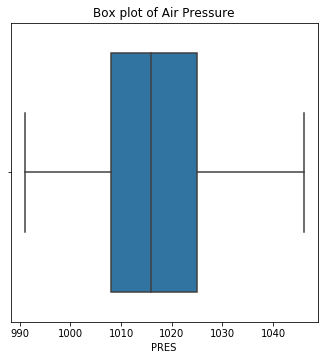

In [4]:
# Let us draw a box plot to visualize the central tendency and dispersion of PRES
plt.figure(figsize=(5.5, 5.5))
g = sns.boxplot(df['PRES'])
g.set_title('Box plot of Air Pressure')

Text(0,0.5,'Air Pressure readings in hPa')

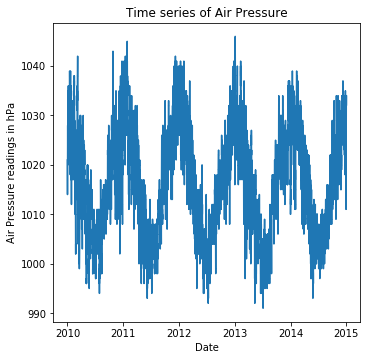

In [5]:
plt.figure(figsize=(5.5, 5.5))
g = sns.lineplot(y=df['PRES'], x=df['datetime'])
g.set_title('Time series of Air Pressure')
g.set_xlabel('Date')
g.set_ylabel('Air Pressure readings in hPa')

Gradient descent algorithms perform better (for example converge faster) if the variables are within range [-1, 1]. Many sources relax the boundary to even [-3, 3]. The PRES variable is mixmax scaled to bound the tranformed variable within [0,1].

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_PRES'] = scaler.fit_transform(np.array(df['PRES']).reshape(-1, 1))
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,scaled_PRES
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00,0.545455
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00,0.527273
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00,0.509091
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00,0.509091
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00,0.490909


Before training the model, the dataset is split in two parts - train set and validation set.
The neural network is trained on the train set. This means computation of the loss function, back propagation
and weights updated by a gradient descent algorithm is done on the train set. The validation set is
used to evaluate the model and to determine the number of epochs in model training. Increasing the number of 
epochs will further decrease the loss function on the train set but might not necessarily have the same effect
for the validation set due to overfitting on the train set.Hence, the number of epochs is controlled by keeping
a tap on the loss function computed for the validation set. We use Keras with Tensorflow backend to define and train
the model. All the steps involved in model training and validation is done by calling appropriate functions
of the Keras API.

In [7]:
# Let's start by splitting the dataset into train and validation. 
# The dataset's time period is from Jan 1st, 2010 to Dec 31st, 2014. 
# The first four years - 2010 to 2013 is used as train
# 2014 is kept for validation.
split_date = datetime.datetime(year=2014, month=1, day=1, hour=0)
df_train = df.loc[df['datetime']<split_date]
df_val = df.loc[df['datetime']>=split_date]
print('Shape of train:', df_train.shape)
print('Shape of test:', df_val.shape)

Shape of train: (35064, 15)
Shape of test: (8760, 15)


In [8]:
# First five rows of train
df_train.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,scaled_PRES
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00,0.545455
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00,0.527273
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00,0.509091
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00,0.509091
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00,0.490909


In [9]:
# Reset the indices of the validation set
df_val.reset_index(drop=True, inplace=True)
# First five rows of validation
df_val.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,scaled_PRES
0,35065,2014,1,1,0,24.0,-20,7.0,1014.0,NW,143.48,0,0,2014-01-01 00:00:00,0.418182
1,35066,2014,1,1,1,53.0,-20,7.0,1013.0,NW,147.50,0,0,2014-01-01 01:00:00,0.400000
2,35067,2014,1,1,2,65.0,-20,6.0,1013.0,NW,151.52,0,0,2014-01-01 02:00:00,0.400000
3,35068,2014,1,1,3,70.0,-20,6.0,1013.0,NW,153.31,0,0,2014-01-01 03:00:00,0.400000
4,35069,2014,1,1,4,79.0,-18,3.0,1012.0,cv,0.89,0,0,2014-01-01 04:00:00,0.381818


Text(0,0.5,'Scaled Air Pressure readings')

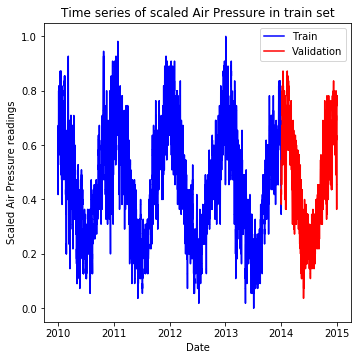

In [10]:
# The train and validation time series of standardized PRES are also plotted
plt.figure(figsize=(5.5, 5.5))
g = sns.lineplot(
    y=df_train['scaled_PRES'],
    x=df_train['datetime'],
    color='b', label='Train'
)
g = sns.lineplot(
    y=df_val['scaled_PRES'],
    x=df_val['datetime'],
    color='r', label='Validation'
)
g.set_title('Time series of scaled Air Pressure in train set')
g.set_xlabel('Date')
g.set_ylabel('Scaled Air Pressure readings')

Now we need to generate regressors (X) and target variable (y) for train and validation. 2-D array of regressors and 1-D array of target is created from the original 1-D array of column standardized_PRES in the DataFrames. For the time series forecasting model, Past seven days of observations are used to predict for the next day. This is equivalent to a AR(7) model. We define a function which takes the original time series and the number of timesteps in regressors as input to generate the arrays of X and y.

In [11]:
def makeXy(ts, nb_timesteps):
    """
    Input: 
           ts: original time series
           nb_timesteps: number of time steps in the regressors
    Output: 
           X: 2-D array of regressors
           y: 1-D array of target 
    """
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        X.append(list(ts.loc[i-nb_timesteps:i-1]))
        y.append(ts.loc[i])
    X, y = np.array(X), np.array(y)
    return X, y

In [12]:
X_train, y_train = makeXy(df_train['scaled_PRES'], 7)
print('Shape of train arrays:', X_train.shape, y_train.shape)

Shape of train arrays: (35057, 7) (35057,)


In [13]:
X_val, y_val = makeXy(df_val['scaled_PRES'], 7)
print('Shape of validation arrays:', X_val.shape, y_val.shape)

Shape of validation arrays: (8753, 7) (8753,)


Now we define the MLP using the Keras Functional API. In this approach a layer can be declared as the input of the following layer at the time of defining the next layer. 

In [14]:
from keras.layers import Dense, Input, Dropout
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [15]:
# Define input layer which has shape (None, 7) and of type float32.
# None indicates the number of instances
input_layer = Input(shape=(7,), dtype='float32')

In [16]:
# Dense layers are defined with linear activation
dense1 = Dense(32, activation='linear')(input_layer)
dense2 = Dense(16, activation='linear')(dense1)
dense3 = Dense(16, activation='linear')(dense2)

Instructions for updating:
Colocations handled automatically by placer.


Multiple hidden layers and large number of neurons in each hidden layer gives neural networks the ability to model complex non-linearity of the underlying relations between regressors and target. However, deep neural networks can also overfit train data and give poor results on validation or test set. Dropout has been effectively used to regularize deep neural networks. In this example, a Dropout layer is added before the output layer. Dropout randomly sets p fraction of input neurons to zero before passing to the next layer. Randomly dropping inputs essentially acts as a bootstrap aggregating or bagging type of model ensembling. Random forest uses bagging by building trees on random subsets of input features. We use p=0.2 to dropout 20% of randomly selected input features.

In [17]:
dropout_layer = Dropout(0.2)(dense3)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
# Finally, the output layer gives prediction for the next day's air pressure.
output_layer = Dense(1, activation='linear')(dropout_layer)

The input, dense and output layers will now be packed inside a Model, which is wrapper class for training and making
predictions. Mean square error (MSE) is used as the loss function.

The network's weights are optimized by the Adam algorithm. Adam stands for adaptive moment estimation
and has been a popular choice for training deep neural networks. Unlike, stochastic gradient descent, Adam uses
different learning rates for each weight and separately updates the same as the training progresses. The learning rate of a weight is updated based on exponentially weighted moving averages of the weight's gradients and the squared gradients.

In [19]:
ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_squared_error', optimizer='adam')
ts_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 1,073
Trainable params: 1,073
Non-trainable params: 0
_________________________________________________________________


The model is trained by calling the fit function on the model object and passing the X_train and y_train. The training is done for a predefined number of epochs. Additionally, batch_size defines the number of samples of train set to be used for a instance of back propagation. The validation dataset is also passed to evaluate the model after every epoch completes. A ModelCheckpoint object tracks the loss function on the validation set and saves the model for the epoch, at which the loss function has been minimum.

In [20]:
save_weights_at = os.path.join(
    'keras_models',
    'PRSA_data_Air_Pressure_MLP_weights.{epoch:02d}-{val_loss:.4f}.hdf5'
)
save_best = ModelCheckpoint(
    save_weights_at, monitor='val_loss',
    verbose=0, save_best_only=True,
    save_weights_only=False, mode='min', period=1
)
ts_model.fit(
    x=X_train, y=y_train, batch_size=16, epochs=20,
    verbose=1, callbacks=[save_best],
    validation_data=(X_val, y_val), shuffle=True
)

Instructions for updating:
Use tf.cast instead.
Train on 35057 samples, validate on 8753 samples
Epoch 1/20
35057/35057 [==============================] - 2s 66us/step - loss: 0.0034 - val_loss: 1.9126e-04
Epoch 2/20
35057/35057 [==============================] - 2s 59us/step - loss: 0.0010 - val_loss: 2.5647e-04
Epoch 3/20
35057/35057 [==============================] - 2s 58us/step - loss: 8.4713e-04 - val_loss: 1.6119e-04
Epoch 4/20
35057/35057 [==============================] - 2s 57us/step - loss: 8.1905e-04 - val_loss: 2.4867e-04
Epoch 5/20
35057/35057 [==============================] - 2s 56us/step - loss: 7.7595e-04 - val_loss: 1.6788e-04
Epoch 6/20
35057/35057 [==============================] - 2s 58us/step - loss: 7.9570e-04 - val_loss: 1.8508e-04
Epoch 7/20
35057/35057 [==============================] - 2s 56us/step - loss: 7.6770e-04 - val_loss: 1.4602e-04
Epoch 8/20
35057/35057 [==============================] - 2s 57us/step - loss: 7.7479e-04 - val_loss: 7.2345e-04
Epoch 9

Prediction are made for the air pressure from the best saved model. The model's predictions, which are on the scaled  air-pressure, are inverse transformed to get predictions on original air pressure. The goodness-of-fit or R squared is also calculated.

In [21]:
best_model = load_model(
    os.path.join(
        'keras_models', 'PRSA_data_Air_Pressure_MLP_weights.20-0.0001.hdf5'
    )
)
preds = best_model.predict(X_val)
pred_PRES = scaler.inverse_transform(preds)
pred_PRES = np.squeeze(pred_PRES)

In [22]:
from sklearn.metrics import r2_score

In [23]:
r2 = r2_score(df_val['PRES'].loc[7:], pred_PRES)
print('R-squared for the validation set:', round(r2, 4))

R-squared for the validation set: 0.9956


Text(0,0.5,'Air Pressure')

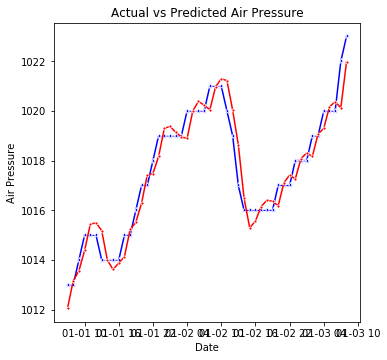

In [24]:
# Let's plot the first 50 actual and predicted values of air pressure.
plt.figure(figsize=(5.5, 5.5))
g = sns.lineplot(
    y=df_val.loc[7:56, 'PRES'], x=df_train.loc[7:56, 'datetime'],
    linestyle='-', marker='*', color='b'
)
g = sns.lineplot(
    y=pred_PRES[:50], x=df_train.loc[7:56, 'datetime'],
    linestyle='-', marker='.', color='r'
)
g.set_title('Actual vs Predicted Air Pressure')
g.set_xlabel('Date')
g.set_ylabel('Air Pressure')